# Inference of EGF pathway

In [8]:
import os
import string

import arviz as az
import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

from growth_factor_model import GrowthFactorModel

The data-generating model is a hierarchical growth factor model
(Dixit et al., 2020) governed by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (p, k_{\mathrm{on}}, k_{\mathrm{off}}, k_{\mathrm{deg}, r}, k_{\mathrm{deg}, a}, \sigma)$ and
$\theta = (\mu_{p}, \mu_{k_{\mathrm{on}}}, \sigma_{p}, \sigma_{k_{\mathrm{on}}}, \theta_{k_{\mathrm{off}}}, \theta_{k_{\mathrm{deg}, r}}, \theta_{k_{\mathrm{deg}, a}}, \theta_{\sigma})$.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) =
        \mathrm{LN}\left( y | \log \bar{y}(\psi, t), \sigma \right)
$$

where $\bar{y} = (c_a, c_r)^t$ models the concentration of activated cell receptors and the inactive cell receptors. The activation dynamics are described by

$$
    \frac{\mathrm{d}c_r}{\mathrm{d}t} =
        p - k_{\mathrm{on}} c_l c_r + k_{\mathrm{off}} c_a - k_{\mathrm{deg}, r} c_r,
    \quad \text{and}\quad
    \frac{\mathrm{d}c_a}{\mathrm{d}t} =
        k_{\mathrm{on}} c_l c_r - k_{\mathrm{off}} c_a - k_{\mathrm{deg}, a} c_a
$$
with initial conditions $c_r(t=0) = c_a(t=0) = 0$.

The inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(p | \mu_{p}, \sigma ^2_{p})\,
        \mathcal{N}(k_{\mathrm{on}} | \mu_{k_{\mathrm{on}}}, \sigma ^2_{k_{\mathrm{on}}})\,
        \delta (k_{\mathrm{off}} - \theta_{k_{\mathrm{off}}})\,
        \delta (k_{\mathrm{deg}, r} - \theta_{k_{\mathrm{deg}, r}})\,
        \delta (k_{\mathrm{deg}, a} - \theta_{k_{\mathrm{deg}, a}})\,
        \delta (\sigma - \theta_{\sigma}).
$$

### Results

Import results

In [2]:
# Import data
directory = os.getcwd()
measurements_df = pd.read_csv(directory + '/data/1_egf_pathway_data.csv')

# Reshape data to numpy array of shape (n_ids_per_t, n_output, n_times)
n_ids = len(measurements_df.ID.unique())
outputs = measurements_df.Observable.unique()
n_outputs = len(outputs)
times = np.sort(measurements_df.Time.unique())
n_ids_per_t = n_ids // n_outputs // len(times)
measurements = np.empty(shape=(n_ids_per_t, n_outputs, len(times)))
for ido, output in enumerate(outputs):
    temp = measurements_df[measurements_df.Observable == output]
    for idt, time in enumerate(times):
        mask = temp.Time == time
        measurements[:, ido, idt] = temp[mask].Value.values

# Define true parameters
true_arameters = [
    1.7,    # Mean activation rate
    0.05,   # Std. activation rate
    8,      # deactivation rate
    0.015,  # degradation rate (active)
    0.25,   # degradation rate (inactive)
    1.7,    # Mean production rate
    0.05,   # Std. production rate
    0.05,  # Sigma act. ligand conc. Amount 1
    0.05,  # Sigma inact. ligand conc. Amount 1
    0.05,  # Sigma act. ligand conc. Amount 2
    0.05]  # Sigma inact. ligand conc. Amount 2

# Define predictive model
mechanistic_model = GrowthFactorModel()
error_models = [
    chi.LogNormalErrorModel(),  # Active ligand concentration Amount 1
    chi.LogNormalErrorModel(),  # Inactive ligand concentration Amount 1
    chi.LogNormalErrorModel(),  # Active ligand concentration Amount 1
    chi.LogNormalErrorModel()]  # Inactive ligand concentration Amount 1
predictive_model = chi.PredictiveModel(mechanistic_model, error_models)

# Define population model
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate'], centered=True),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'], centered=True),
    chi.PooledModel(n_dim=4, dim_names=[
        'Sigma act. ligand conc. Amount 1',
        'Sigma inact. ligand conc. Amount 1',
        'Sigma act. ligand conc. Amount 2',
        'Sigma inact. ligand conc. Amount 2']),
    chi.PooledModel(dim_names=['Sigma'])])

# Import NLME inference results
results = xr.load_dataset(
    directory + '/posteriors/filter_inference_egf_pathway.nc')

Visualise results

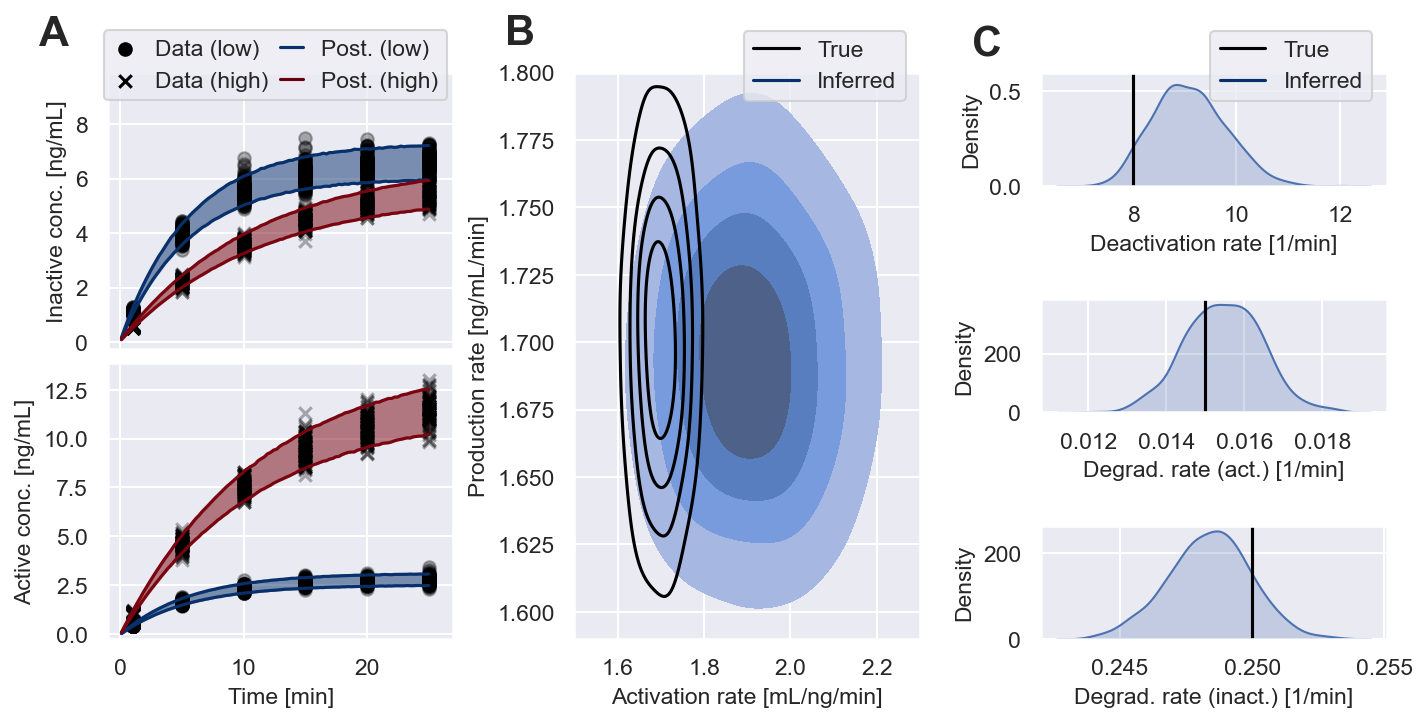

In [4]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.35)

# Create time series axes
inner = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[0], hspace=0.05)
ax1 = plt.Subplot(fig, inner[0])
ax2 = plt.Subplot(fig, inner[1])
ax1.sharex(ax2)
time_series_axes = [ax1, ax2]

# Create axis for IIV parameters
ax3 = plt.Subplot(fig, outer[1])

# Create axes for pooled parameters
inner = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=outer[2], hspace=1)
ax4 = plt.Subplot(fig, inner[0])
ax5 = plt.Subplot(fig, inner[1])
ax6 = plt.Subplot(fig, inner[2])
param_axes = [ax3, ax4, ax5, ax6]

# Add axes to figure
for ax in (time_series_axes + param_axes):
    fig.add_subplot(ax)

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate']),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters = np.vstack([
    results['Mean myokit.activation_rate'].values.flatten(),
    results['Std. myokit.activation_rate'].values.flatten(),
    results['Pooled myokit.deactivation_rate'].values.flatten(),
    results[
        'Pooled myokit.degradation_rate_active_receptor'].values.flatten(),
    results[
        'Pooled myokit.degradation_rate_inactive_receptor'].values.flatten(),
    results['Mean myokit.production_rate'].values.flatten(),
    results['Std. myokit.production_rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 5))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
sns.kdeplot(
    x=samples[:, 1], fill=True, ax=param_axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=samples[:, 2], fill=True, ax=param_axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=samples[:, 3], fill=True, ax=param_axes[3], bw_adjust=1.5)

# Plot population filter inference results (measurement space)
times = np.linspace(0.1, 25, 100)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_models)
simulated_measurements = np.empty(shape=(n_samples, 4, n_times))
parameters = np.empty(shape=(n_samples, 9))
parameters[:, :5] = samples
parameters[:, 5] = true_arameters[-4]
parameters[:, 6] = true_arameters[-3]
parameters[:, 7] = true_arameters[-2]
parameters[:, 8] = true_arameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[..., 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
time_series_axes[0].plot(
    times, fifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].plot(
    times, ninetyfifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].fill_between(
    times, fifth_percentile[1], ninetyfifth_percentile[1],
    color=plt.get_cmap('Blues_r')(1), alpha=0.5)
time_series_axes[0].plot(
    times, fifth_percentile[3], color=plt.get_cmap('Reds_r')(10))
time_series_axes[0].plot(
    times, ninetyfifth_percentile[3], color=plt.get_cmap('Reds_r')(10))
time_series_axes[0].fill_between(
    times, fifth_percentile[3], ninetyfifth_percentile[3],
    color=plt.get_cmap('Reds_r')(10), alpha=0.5)
time_series_axes[1].plot(
    times, fifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].plot(
    times, ninetyfifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].fill_between(
    times, fifth_percentile[0], ninetyfifth_percentile[0],
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)
time_series_axes[1].plot(
    times, fifth_percentile[2], color=plt.get_cmap('Reds_r')(10))
time_series_axes[1].plot(
    times, ninetyfifth_percentile[2], color=plt.get_cmap('Reds_r')(10))
time_series_axes[1].fill_between(
    times, fifth_percentile[2], ninetyfifth_percentile[2],
    color=plt.get_cmap('Reds_r')(10), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(
    true_arameters[:-4], n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0], linestyles='solid')
param_axes[1].axvline(x=true_arameters[2], color='black', linestyle='solid')
param_axes[2].axvline(x=true_arameters[3], color='black', linestyle='solid')
param_axes[3].axvline(x=true_arameters[4], color='black', linestyle='solid')

# Plot measurement used for the inference as reference
times = np.array([1, 5, 10, 15, 20, 25])
for idm, meas in enumerate(measurements):
    time_series_axes[1].scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)
    time_series_axes[0].scatter(
        times, meas[1], color='black', marker='o', alpha=0.3)
    time_series_axes[1].scatter(
        times, meas[2], color='black', marker='x', alpha=0.3)
    time_series_axes[0].scatter(
        times, meas[3], color='black', marker='x', alpha=0.3)

# Label axes
time_series_axes[1].set_xlabel('Time [min]', fontsize=fontsize)
time_series_axes[0].set_ylabel('Inactive conc. [ng/mL]', fontsize=fontsize)
time_series_axes[1].set_ylabel('Active conc. [ng/mL]', fontsize=fontsize)
time_series_axes[0].tick_params(labelsize=fontsize)
time_series_axes[1].tick_params(labelsize=fontsize)
time_series_axes[0].scatter(
    [10, 10], [100, 101], color='black', linestyle='solid', marker='o',
    label='Data (low)')
time_series_axes[0].scatter(
    [10, 10], [100, 101], color='black', linestyle='solid', marker='x',
    label='Data (high)')
time_series_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Post. (low)')
time_series_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Reds_r')(0),
    linestyle='solid', label='Post. (high)')
time_series_axes[0].set_xlim([-1, 27])
time_series_axes[0].set_ylim([-0.25, 9.9])
time_series_axes[1].set_ylim([-0.25, 13.9])
param_axes[0].plot(
    [10, 10], [100, 101], color='black', label='True')
param_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
param_axes[1].plot(
    [8, 8], [100, 101], color='black', label='True')
param_axes[1].plot(
    [8, 8], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
param_axes[0].set_xlim([1.5, 2.3])
param_axes[0].set_ylim([1.59, 1.8])
param_axes[1].set_ylim([0, 0.6])
param_axes[0].set_xlabel('Activation rate [mL/ng/min]', fontsize=fontsize)
param_axes[0].set_ylabel('Production rate [ng/mL/min]', fontsize=fontsize)
param_axes[0].tick_params(labelsize=fontsize)
param_axes[1].set_xlabel('Deactivation rate [1/min]', fontsize=fontsize)
param_axes[1].set_ylabel('Density', fontsize=fontsize)
param_axes[1].tick_params(labelsize=fontsize)
param_axes[2].set_xlabel('Degrad. rate (act.) [1/min]', fontsize=fontsize)
param_axes[2].set_ylabel('Density', fontsize=fontsize)
param_axes[2].tick_params(labelsize=fontsize)
param_axes[3].set_xlabel('Degrad. rate (inact.) [1/min]', fontsize=fontsize)
param_axes[3].set_ylabel('Density', fontsize=fontsize)
param_axes[3].tick_params(labelsize=fontsize)
time_series_axes[0].legend(
    fontsize=fontsize, loc=[-0.01, 0.9], ncol=2, handlelength=1,
    columnspacing=0.5)
param_axes[0].legend(fontsize=fontsize, loc=[0.49, 0.95])
param_axes[1].legend(fontsize=fontsize, loc=[0.49, 0.75])

# Label subplot groups
ax1.text(
    -0.2, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, size=20,
    weight='bold')
ax3.text(
    -0.2, 1.05, string.ascii_uppercase[1], transform=ax3.transAxes, size=20,
    weight='bold')
ax4.text(
    -0.2, 1.15, string.ascii_uppercase[2], transform=ax4.transAxes, size=20,
    weight='bold')
plt.savefig('6_egf_pathway_inference_results.pdf', bbox_inches='tight')
plt.savefig('6_egf_pathway_inference_results.tif', bbox_inches='tight')
plt.show()

## Visualise inference results when deactivation rate is fixed

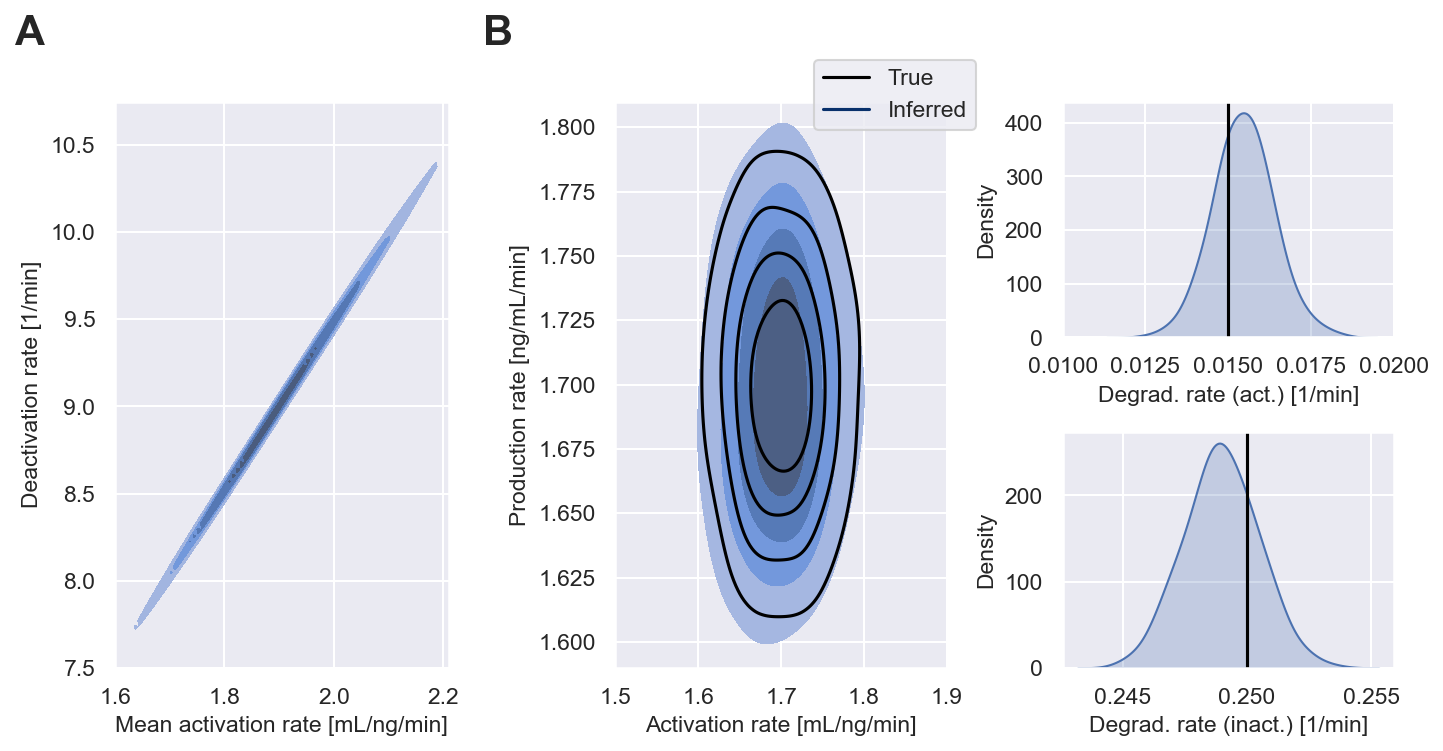

In [5]:
# Import results
results_reduced = xr.load_dataset(
    directory + '/posteriors/filter_inference_egf_pathway_reduced.nc')

# Plot results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.3, width_ratios=[0.3, 0.7])

# Create correlation plot axis
ax1 = plt.Subplot(fig, outer[0])

# Create axis for IIV parameters
inner = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer[1], wspace=0.35)
ax2 = plt.Subplot(fig, inner[0])

# Create axes for pooled parameters
inner2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=inner[1], hspace=0.4)
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

# Add axes to figure
for ax in [ax1, ax2, ax3, ax4]:
    fig.add_subplot(ax)

# Plot correlation plot
parameters = np.vstack([
    results['Mean myokit.activation_rate'].values.flatten(),
    results['Pooled myokit.deactivation_rate'].values.flatten()])
sns.kdeplot(
    x=parameters[0], y=parameters[1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax1)

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate']),
    chi.PooledModel(n_dim=2, dim_names=[
        'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 1000
parameters = np.vstack([
    results_reduced['Mean myokit.activation_rate'].values.flatten(),
    results_reduced['Std. myokit.activation_rate'].values.flatten(),
    results_reduced[
        'Pooled myokit.degradation_rate_active_receptor'].values.flatten(),
    results_reduced[
        'Pooled myokit.degradation_rate_inactive_receptor'].values.flatten(),
    results_reduced['Mean myokit.production_rate'].values.flatten(),
    results_reduced['Std. myokit.production_rate'].values.flatten()]).T
# parameters = parameters[
#     np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 4))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 3], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax2)
sns.kdeplot(
    x=samples[:, 1], fill=True, ax=ax3, bw_adjust=1.5)
sns.kdeplot(
    x=samples[:, 2], fill=True, ax=ax4, bw_adjust=1.5)

# Plot data-generating distribution as reference to parameter space
n_samples = 10000
p = true_arameters[:2] + true_arameters[3:-4]
samples = population_model.sample(p, n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 3], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=ax2, linestyles='solid')
ax3.axvline(x=true_arameters[3], color='black', linestyle='solid')
ax4.axvline(x=true_arameters[4], color='black', linestyle='solid')

# Label axes
ax1.set_xlim([1.6, 2.21])
ax1.set_ylim([7.5, 10.75])
ax1.set_xlabel('Mean activation rate [mL/ng/min]', fontsize=fontsize)
ax1.set_ylabel('Deactivation rate [1/min]', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax2.set_xlim([1.5, 1.9])
ax2.set_ylim([1.59, 1.81])
ax2.set_xlabel('Activation rate [mL/ng/min]', fontsize=fontsize)
ax2.set_ylabel('Production rate [ng/mL/min]', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.set_xlabel('Degrad. rate (act.) [1/min]', fontsize=fontsize)
ax3.set_ylabel('Density', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax3.set_xlim([0.01, 0.02])
ax4.set_xlabel('Degrad. rate (inact.) [1/min]', fontsize=fontsize)
ax4.set_ylabel('Density', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize)
ax2.plot(
    [10, 10], [100, 101], color='black', label='True')
ax2.plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
ax2.legend(loc=[0.6, 0.95])

# Label subplot groups
ax1.text(
    -0.3, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, size=20,
    weight='bold')
ax2.text(
    -0.4, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, size=20,
    weight='bold')
plt.savefig('7_egf_pathway_inference_results_reduced.pdf', bbox_inches='tight')
plt.savefig('7_egf_pathway_inference_results_reduced.tif', bbox_inches='tight')
plt.show()

## 2. Visualise computational costs of log-posterior evaluations

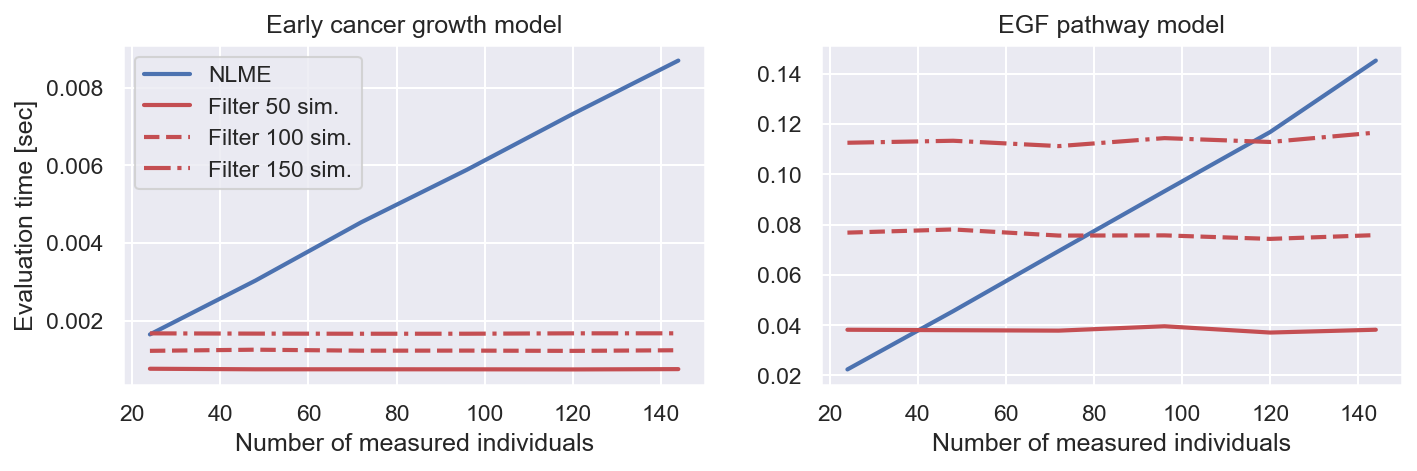

In [6]:
# Import scaling results with number of snapshot measurements
directory = os.path.dirname(os.getcwd())
cancer_data = pd.read_csv(directory + '/1_cancer_growth/scaling_with_measurements.csv')

directory = os.getcwd()
egf_data = pd.read_csv(directory + '/scaling_with_measurements.csv')

# Plot results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes[0].sharex(axes[1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot scaling behaviour
# Cancer growth model
mask = cancer_data.Type == 'NLME'
n_ids = cancer_data[mask]['Number of measured individuals']
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'], label='NLME', linewidth=2)
mask = cancer_data.Type == 'Filter 50'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 50 sim.',
    color=sns.color_palette()[3], linestyle='solid', linewidth=2)
mask = cancer_data.Type == 'Filter 100'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 100 sim.',
    color=sns.color_palette()[3], linestyle='--', linewidth=2)
mask = cancer_data.Type == 'Filter 150'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 150 sim.',
    color=sns.color_palette()[3], linestyle='-.', linewidth=2)

# EGF model
mask = egf_data.Type == 'NLME'
n_ids = egf_data[mask]['Number of measured individuals']
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'], label='NLME', linewidth=2)
mask = egf_data.Type == 'Filter 50'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 50 sim.',
    color=sns.color_palette()[3], linestyle='solid', linewidth=2)
mask = egf_data.Type == 'Filter 100'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 100 sim.',
    color=sns.color_palette()[3], linestyle='--', linewidth=2)
mask = egf_data.Type == 'Filter 150'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 150 sim.',
    color=sns.color_palette()[3], linestyle='-.', linewidth=2)

# Labelling
axes[0].set_xlabel('Number of measured individuals')
axes[0].set_ylabel('Evaluation time [sec]')
axes[1].set_xlabel('Number of measured individuals')
axes[1].set_ylabel('')
axes[1].set_title('EGF pathway model')
axes[0].set_title('Early cancer growth model')
axes[0].legend()

directory = os.getcwd()
plt.savefig(
    directory + '/8_computational_costs_of_log_posterior_evaluations.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/8_computational_costs_of_log_posterior_evaluations.pdf',
    bbox_inches='tight')

plt.show()

## 3. Number of log-posterior evaluations to converge

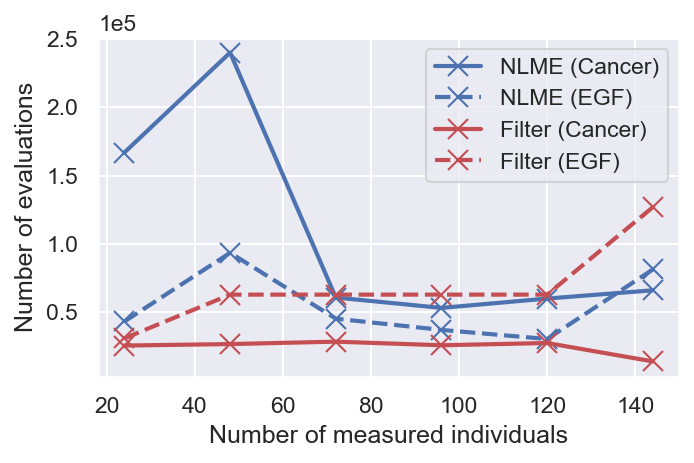

In [7]:
# Import cancer modelling results
directory = os.path.dirname(os.getcwd())
cancer_results = pd.read_csv(
    directory + '/1_cancer_growth/number_of_evaluations.csv')

# Import EGF modelling results
directory = os.getcwd()
egf_results = pd.read_csv(
    directory + '/number_of_evaluations.csv')

# Visualise
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(1125 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot number of evaluations
mask = cancer_results.Type == 'NLME'
n_ids = cancer_results[mask]['Number of measured individuals']
n_eval = cancer_results[mask]['Number of evaluations']
axes[0].plot(
    n_ids, n_eval, color=sns.color_palette()[0], label='NLME (Cancer)',
    marker='x', linewidth=2, ms=10)

mask = egf_results.Type == 'NLME'
n_ids = egf_results[mask]['Number of measured individuals']
n_eval = egf_results[mask]['Number of evaluations']
axes[0].plot(
    n_ids, n_eval, color=sns.color_palette()[0], label='NLME (EGF)',
    marker='x', linewidth=2, ms=10, linestyle='dashed')

mask = cancer_results.Type == 'Filter 100'
n_ids = cancer_results[mask]['Number of measured individuals']
n_eval = cancer_results[mask]['Number of evaluations']
axes[0].plot(
    n_ids, n_eval, color=sns.color_palette()[3], label='Filter (Cancer)',
    marker='x', linewidth=2, ms=10)

mask = egf_results.Type == 'Filter 100'
n_ids = egf_results[mask]['Number of measured individuals']
n_eval = egf_results[mask]['Number of evaluations']
axes[0].plot(
    n_ids, n_eval, color=sns.color_palette()[3], label='Filter (EGF)',
    marker='x', linewidth=2, ms=10, linestyle='dashed')

# Labelling
axes[0].set_xlabel('Number of measured individuals')
axes[0].set_ylabel('Number of evaluations')
axes[0].ticklabel_format(axis='y', style='scientific', scilimits=(0, 2))
plt.legend()

directory = os.getcwd()
plt.savefig(
    directory + '/9_computational_costs_number_of_evaluations.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/9_computational_costs_number_of_evaluations.pdf',
    bbox_inches='tight')

plt.show()

## 4. Scaling of filter inference - Metropolis-Hastings vs. NUTS

Import data

In [9]:
# Import Cancer modelling results
directory = os.path.dirname(os.getcwd())
cancer_results = []
cancer_results.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '2_filter_inference_cancer_growth_15.nc')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '3_filter_inference_cancer_growth_45.nc')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '4_filter_inference_cancer_growth_135.nc')
)
cancer_results.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '5_filter_inference_cancer_growth_405.nc')
)

cancer_results_mh = []
cancer_results_mh.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '99_filter_inference_metropolis_hastings_cancer_growth' +
        '_100_sim_ids_15_ids.nc')
)
cancer_results_mh.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '100_filter_inference_metropolis_hastings_cancer_growth' +
        '_100_sim_ids_45_ids.nc')
)
cancer_results_mh.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '101_filter_inference_metropolis_hastings_cancer_growth' +
        '_100_sim_ids_135_ids.nc')
)
cancer_results_mh.append(
    xr.load_dataset(
        directory +
        '/1_cancer_growth/posteriors/' +
        '102_filter_inference_metropolis_hastings_cancer_growth' +
        '_100_sim_ids_405_ids.nc')
)

# Import EGF results
directory = os.getcwd()
egf_results = xr.load_dataset(
    directory + '/posteriors/filter_inference_egf_pathway_reduced.nc')

egf_results_mh = xr.load_dataset(
    directory +
    '/posteriors/99_filter_inference_metropolis_hastings_egf_100_ids.nc')

Visualise results

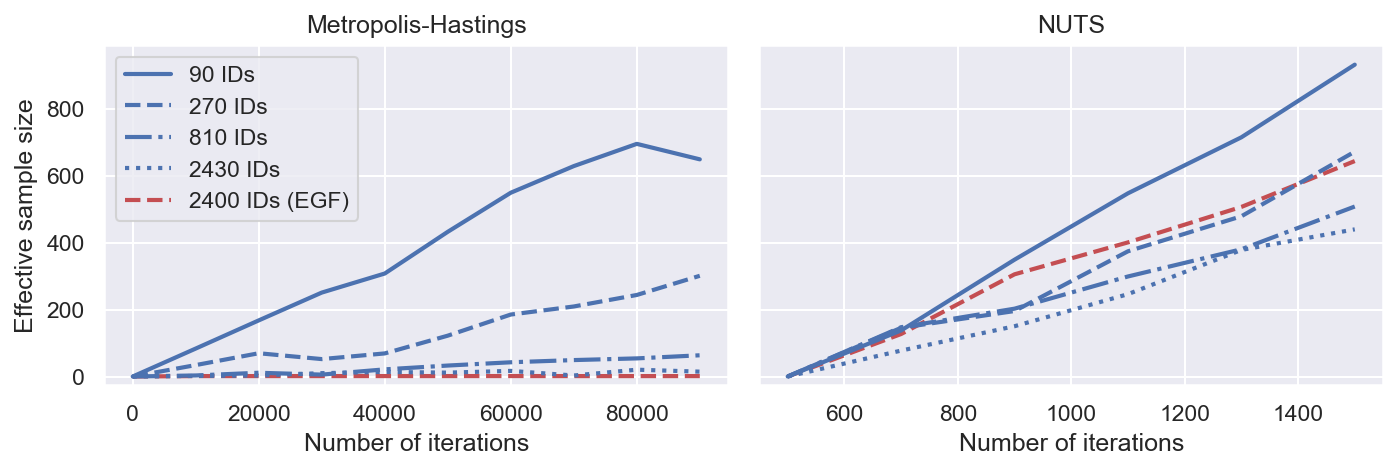

In [10]:
# Visualise
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.05)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot scaling behaviour
# Compute ESS of cancer model inference using NUTS
parameters = [
    'Mean Initial count',
    'Mean Growth rate',
    'Std. Initial count',
    'Std. Growth rate',
    'Sigma Count']
n_iterations = [500, 700, 900, 1100, 1300, 1500]
mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(cancer_results[0][parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[1].plot(n_iterations, mean, label='90 IDs', linewidth=2)

mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(cancer_results[1][parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[1].plot(
    n_iterations, mean, label='270 IDs',
    linestyle='dashed', color=sns.color_palette()[0], linewidth=2)

mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(cancer_results[2][parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[1].plot(
    n_iterations, mean, label='810 IDs',
    linestyle='-.', color=sns.color_palette()[0], linewidth=2)

mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(cancer_results[3][parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[1].plot(
    n_iterations, mean, label='2430 IDs',
    linestyle='dotted', color=sns.color_palette()[0], linewidth=2)

# Compute ESS of EGF inference using NUTS
parameters = [
    'Mean myokit.activation_rate',
    'Std. myokit.activation_rate',
    'Pooled myokit.degradation_rate_active_receptor',
    'Pooled myokit.degradation_rate_inactive_receptor',
    'Mean myokit.production_rate',
    'Std. myokit.production_rate']
n_iterations = [500, 700, 900, 1100, 1300, 1500]
mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(egf_results[parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[1].plot(
    n_iterations, mean, label='2400 IDs (EGF)', color=sns.color_palette()[3],
    zorder=1, linestyle='dashed', linewidth=2)

# Compute ESS of cancer model inference using Metropolis-Hastings
parameters = [
    'Mean Initial count',
    'Mean Growth rate',
    'Std. Initial count',
    'Std. Growth rate',
    'Pooled Sigma']
n_iterations = [
    0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
mean = []
for n in n_iterations:
    if n == 0:
        mean += [0]
        continue

    ess = az.ess(cancer_results_mh[0][parameters].sel(draw=slice(0, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(n_iterations, mean, label='90 IDs', linewidth=2)

mean = []
for n in n_iterations:
    if n == 0:
        mean += [0]
        continue

    ess = az.ess(cancer_results_mh[1][parameters].sel(draw=slice(0, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(
    n_iterations, mean, label='270 IDs',
    color=sns.color_palette()[0], linestyle='dashed', linewidth=2)

mean = []
for n in n_iterations:
    if n == 0:
        mean += [0]
        continue

    ess = az.ess(cancer_results_mh[2][parameters].sel(draw=slice(0, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(
    n_iterations, mean, label='810 IDs',
    color=sns.color_palette()[0], linestyle='-.', linewidth=2)

mean = []
for n in n_iterations:
    if n == 0:
        mean += [0]
        continue

    ess = az.ess(cancer_results_mh[3][parameters].sel(draw=slice(0, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(
    n_iterations, mean, label='2430 IDs',
    color=sns.color_palette()[0], linestyle='dotted', linewidth=2)

# Compute ESS of EGF inference using Metropolos-Hastings
parameters = [
    'Mean Activation rate',
    'Std. Activation rate',
    'Pooled Deg. rate (act.)',
    'Pooled Deg. rate (inact.)',
    'Mean Production rate',
    'Std. Production rate']
mean = []
for n in n_iterations:
    if n == 0:
        mean += [0]
        continue

    ess = az.ess(egf_results_mh[parameters].sel(draw=slice(0, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(n_iterations, mean,label='2400 IDs (EGF)', color=sns.color_palette()[3],
    zorder=1, linestyle='dashed', linewidth=2)

# Labelling
axes[0].set_xlabel('Number of iterations')
axes[0].set_ylabel('Effective sample size')
axes[1].set_title('NUTS')
axes[1].set_xlabel('Number of iterations')
axes[1].set_ylabel('')
axes[0].set_title('Metropolis-Hastings')
axes[1].set_yticklabels([])
axes[0].set_ylim([-25, 990])
axes[1].set_ylim([-25, 990])
axes[0].legend()

directory = os.getcwd()
plt.savefig(
    directory + '/10_nuts_versus_metropolis_hastings.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/10_nuts_versus_metropolis_hastings.pdf',
    bbox_inches='tight')

plt.show()